In [2]:
from process_data import clean_data, create_index, pivot_data, clean_data2
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Activation, TimeDistributed
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.models import load_model
import matplotlib.pyplot as plt
import time
import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

Using TensorFlow backend.


In [3]:
def data_mimo(X,y,lookback=1):
    newX = []
    newY = []
    for i in range(len(y)-lookback):
        newX.append(X[i:i+1+lookback,:])
        newY.append(y[i:i+1+lookback])
    return np.array(newX), np.array(newY)



def mlp(lookback,num_features):
    model = Sequential()
    model.add(TimeDistributed(Dense(2*lookback+1,activation='tanh'), input_shape=(lookback+1,num_features)))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(lookback+1,activation='tanh')))
    model.add(Dropout(0.2))
    model.add(TimeDistributed(Dense(1,activation='linear')))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model


def train_rnn(df,date_predict,lookback,epochs=100):
    #Preparting data to Train
    print('Preparing data to Train')
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=90+lookback//24)).strftime('%Y-%m-%d')
    sk = df[:date_limit].copy()
    print(sk.shape)
    sk = sk.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #sk.hourofday = sk.hourofday.dt.seconds/3600
    sk = sk[date_start:]
    #sk = sk[24:]
    print('Shape os SK:',sk.shape)
    y = sk.pop('DAENERGY').values
    X = sk.values[:,1:]
    X, y = data_mimo(X,y,lookback)
    y = y.reshape(len(y),y.shape[1],1)
    print('Shape of X',X.shape)
    #X = X[1:]
    #y = y[1:]
    print('Shape of X',X.shape)
    print('YYYY')
    print(y.shape)
    
    model = mlp(lookback,X.shape[2])
    #model = create_rnn(lookback,X.shape[2])

    #X = X.reshape(X.shape[0],X.shape[1],1)
    filepath="weights-improvement-{epoch:02d}-{val_loss:.2f}.hdf5"
    filepath="best_model_mlp-mimo-2.hdf5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
    tensorboard = TensorBoard(log_dir='./logs/mlp'+str(time.time()), 
                              histogram_freq=0, 
                              batch_size=24, 
                              write_graph=True, 
                              write_grads=False, 
                              write_images=True, 
                              )
    # #Training Model
    model.fit(
        X,
        y,
        batch_size=24,  #168, 
        epochs=epochs,
        shuffle = False,
        validation_split=0.1, callbacks=[tensorboard, checkpoint, early_stop])  #0.0857 #0.05 #0.1

    #preparing data to Predict
    return model, X, y

def predict_day(date_predict,model,lookback=168):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict = df.copy()
    df_predict = df_predict[:date_predict]

    df_predict = df_predict.drop(['TRADEDATE', 'RTENERGY'], axis=1)

    #df_predict.hourofday = df_predict.hourofday.dt.seconds/3600
    df_predict = df_predict[date_start:]
    y = df_predict.pop('DAENERGY').values
    X = df_predict.values[:,1:]
    #X,y = data_lstm(X,y,lookback)
    X,y = data_mimo(X,y,lookback)
    input_p = X[-24:]   #-24
    input_p = X[-1:]
    pred = model.predict(input_p,batch_size=1)

    results = df[date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast'] = pred[0]
    RMSE = get_rmse(results['DAENERGY'].values, pred)
    return results, RMSE

def plot_results(results,date_predict):
    RMSE = get_rmse(results['DAENERGY'], results['forecast'])
    fig, ax = plt.subplots(figsize=(9,4))
    # npre = 24
    ax.set(title='DAENERGY '+ 'RMSE: {:.3f} for {}'.format(RMSE, date_predict), xlabel='Date', ylabel='Price DAENERGY')
    #
    # # Plot data points
    results['DAENERGY'].plot(ax=ax, style='o', label='Observed')
    #
    # # Plot predictions
    results.forecast.plot(ax=ax, style='r--', label='forecast')
    # #ci = predict_ci.loc[date_predict]
    # #ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)
    legend = ax.legend(loc='lower right')


def get_rmse(pred,real):
    return np.sqrt(((pred-real)**2).sum()/pred.shape[0])

def create_date_range(start_date, end_date):
    start_dt = datetime.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_dt = datetime.datetime.strptime(end_date, "%Y-%m-%d").date()
    dates = []
    cur_dt = start_dt
    dates.append(start_date)
    while cur_dt<end_dt:
        cur_dt = cur_dt + datetime.timedelta(days=1)
        dates.append(cur_dt.strftime('%Y-%m-%d'))
    return dates


def create_features(df):
    df = df.copy()
    features = ['Ph-1', 'Ph-2', 'Ph-3', 'Ph-24', 'Ph-25', 'Ph-48', 'Ph-49',
                'Ph-72','Ph-73', 'Ph-96', 'Ph-97', 'Ph-120', 'Ph-121', 'Ph-144',
                'Ph-145', 'Ph-168']
    deltas = [1, 2, 3, 24, 25, 48, 49, 72, 73, 96, 97, 120, 121, 144, 145, 168]

    for col, shift in zip(features, deltas):
        df[col] = df.DAENERGY.shift(shift)
    return df

def create_rollings(df):
    df = df.copy()
    means_cols = ['mean_3','mean_6','mean_9','mean_12','mean_24']
    means_values = [3,6,9,12,24]
    
    for col, val in zip(means_cols, means_values):
        df[col] = pd.Series.rolling(df.DAENERGY, window=val, center = False).mean()
        df[col] = df[col].shift(24)
    
    #df['p_1'] = df.DAENERGY.shift(1)
    df['p_24'] = df.DAENERGY.shift(24)
    df['p_48'] = df.DAENERGY.shift(48)
    return df        

def MAPE(y_true, y_pred):
    return 1.0/len(y_true)*(np.abs((y_true-y_pred))/y_true*100).sum()

from keras.optimizers import RMSprop, Adam, Adadelta



In [4]:
df = pivot_data('../data/Data.txt')
#scaler = MinMaxScaler(feature_range=(-1,1)).fit(df.DAENERGY)
#df.DAENERGY = scaler.transform(df.DAENERGY)
df = clean_data(df)
df = create_index(df)
df2 = pivot_data('../data/FurtherBack.txt','2017-05-15','2017-07-07')
df2 = clean_data2(df2)
df2 = create_index(df2)
df = pd.concat([df2,df])


df = create_rollings(df)
df = df.dropna()

wdf = pd.read_csv('../data/wstation.csv', delim_whitespace=True)
temp_cols = []
cols = df.columns.values
for col in cols:
    if len(col)==4 and col not in ['LOAD', 'p_48', 'p_72']:
        temp_cols.append(col)
        
wdf = wdf.drop_duplicates(subset = ['CALL'])

temps = pd.DataFrame(temp_cols)
temps.columns = ['CALL']
result = pd.merge(temps, wdf, how='left', on=['CALL'])
result = result[['CALL','LAT','LON']]
result = result.dropna()

from sklearn.cluster import KMeans
clusters = KMeans(n_clusters = 4).fit(result[['LAT','LON']])

result['Cluster'] = clusters.labels_

df['Temp_C_0']=df[result[result.Cluster==0]['CALL']].mean(axis=1)
df['Temp_C_1']=df[result[result.Cluster==1]['CALL']].mean(axis=1)
df['Temp_C_2']=df[result[result.Cluster==2]['CALL']].mean(axis=1)
df['Temp_C_3']=df[result[result.Cluster==3]['CALL']].mean(axis=1)

df = df.drop(temp_cols, axis=1)


list_scalers = dict()
for c in df.columns.values:
    list_scalers[c] = MinMaxScaler()
    list_scalers[c].fit(df[c].values.reshape(-1,1))
    df[c] = list_scalers[c].transform(df[c].values.reshape(-1,1))


print('Training the model...')

lookback=23#72#48#168

Training the model...


/home/andyk/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype datetime64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/andyk/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/andyk/tensorflow/local/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype timedelta64[ns] was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


In [5]:
lookback=23

In [6]:
#df.DAENERGY = list_scalers['DAENERGY'].inverse_transform(df.DAENERGY.values)
start = time.time()
model, X, y = train_rnn(df,'2017-09-15',lookback=23,epochs=500)
print('Training time : {}'.format(time.time() - start))

Preparing data to Train
(2951, 18)
('Shape os SK:', (2208, 16))
('Shape of X', (2185, 24, 14))
('Shape of X', (2185, 24, 14))
YYYY
(2185, 24, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 24, 47)            705       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 47)            0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 24, 24)            1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 24, 24)            0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 24, 1)             25        
Total params: 1,882
Trainable params: 1,882
Non-trainable params: 0
_____________________________________________________________

1966/1966 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0018
Epoch 35/500
1966/1966 [==============================] - 0s - loss: 0.0019 - val_loss: 0.0018
Epoch 36/500
1966/1966 [==============================] - 0s - loss: 0.0018 - val_loss: 0.0019
Epoch 00035: early stopping
Training time : 58.9979081154


In [7]:
model = load_model('best_model_mlp-mimo-2.hdf5')

In [8]:
%matplotlib inline

MAPE mean:8.17


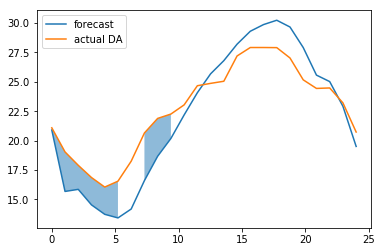

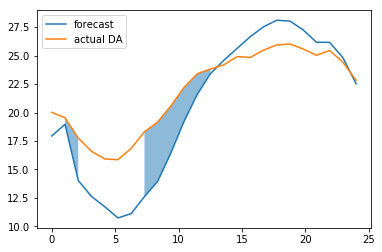

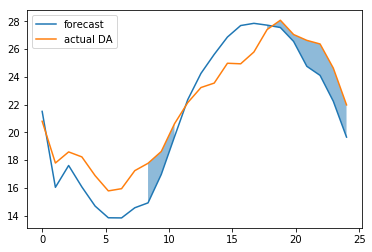

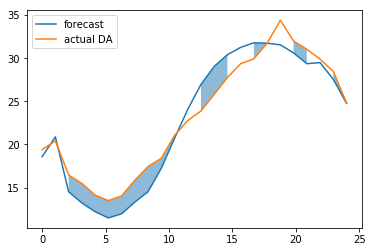

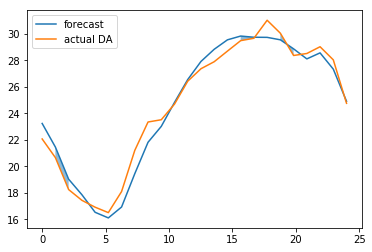

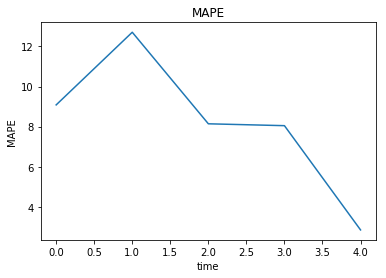

In [9]:
MAPEs = []
for day in create_date_range('2017-09-01','2017-09-5'):
    #print(day)
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    #plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    y_true =y_true.reshape(24)
    y_pred = y_pred.reshape(24)
    y_rt = y_rt.reshape(24)
    mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)


plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:15.16


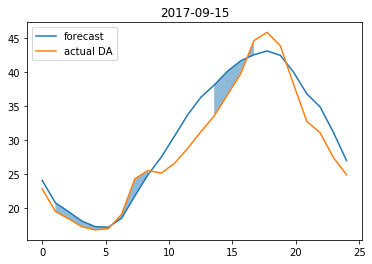

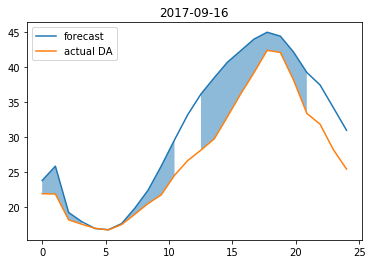

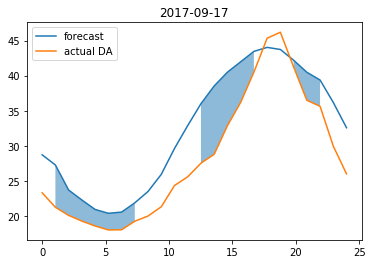

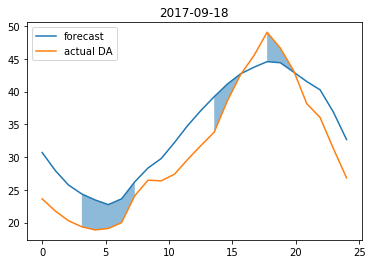

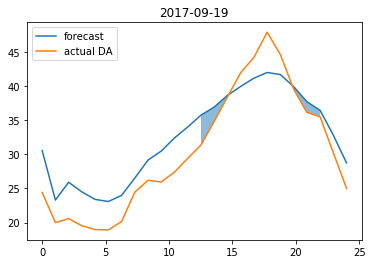

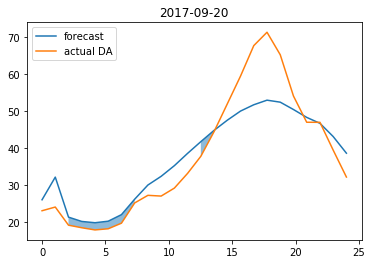

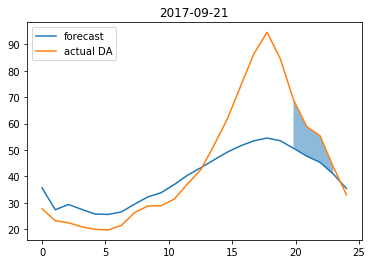

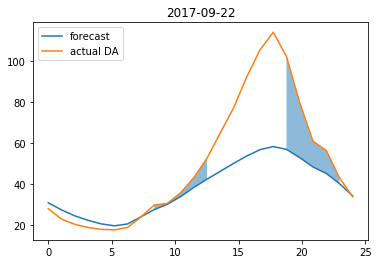

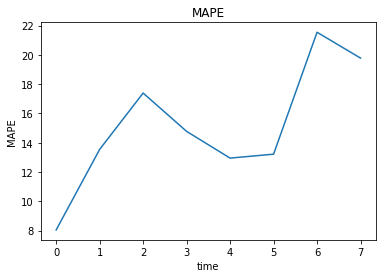

In [11]:
MAPEs=[]
for day in create_date_range('2017-09-15','2017-09-22'):
    results, rmse = predict_day(day,model,lookback)
    plt.figure()
    #results.DAENERGY.plot()
    #results.forecast.plot()
    y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
    y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
    MAPEs.append(MAPE(y_true, y_pred))
    y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
    X  = np.linspace(0,24,24)
    plt.plot(X,y_pred, label='forecast')
    plt.plot(X,y_true, label='actual DA')
    #plt.plot(X,y_rt, label='RT')
    plt.legend(loc='best')
    plt.title(day)
    y_true =y_true.reshape(24)
    y_pred = y_pred.reshape(24)
    y_rt = y_rt.reshape(24)
    mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))
    plt.fill_between(X,y_pred.reshape(24), y_true.reshape(24), where=mask, alpha = 0.5)
plt.figure()
plt.plot(MAPEs)
plt.title('MAPE')
plt.xlabel('time')
plt.ylabel('MAPE')
print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

MAPE mean:8.05


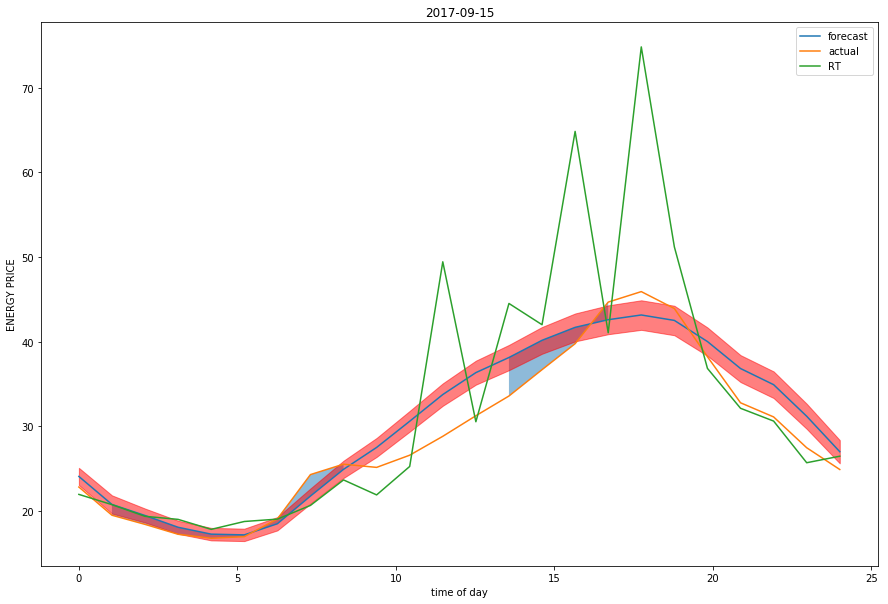

In [14]:
MAPEs=[]
day ='2017-09-15'
results, rmse = predict_day(day,model,lookback)
plt.figure(figsize = (15,10))
#results.DAENERGY.plot()
#results.forecast.plot()
#results.RTENERGY.plot()
y_pred = list_scalers['DAENERGY'].inverse_transform(results.forecast.values.reshape(-1,1))
y_true = list_scalers['DAENERGY'].inverse_transform(results.DAENERGY.values.reshape(-1,1))
y_rt = list_scalers['RTENERGY'].inverse_transform(results.RTENERGY.values.reshape(-1,1))
y_true =y_true.reshape(24)
y_pred = y_pred.reshape(24)
y_rt = y_rt.reshape(24)
mask = ((y_rt > y_true) & (y_pred > y_true)) | ((y_rt < y_true) & (y_pred < y_true))



ci = get_ci(day,model)
y_ci_u = list_scalers['DAENERGY'].inverse_transform(ci.forecast_high.values.reshape(-1,1)).reshape(24)
y_ci_l = list_scalers['DAENERGY'].inverse_transform(ci.forecast_low.values.reshape(-1,1)).reshape(24)

X  = np.linspace(0,24,24)
plt.plot(X,y_pred, label='forecast')
plt.plot(X,y_true, label = 'actual')
plt.plot(X,y_rt, label = 'RT')
#plt.plot(X,y_ci_u, '.',label = 'upper_level')
#plt.plot(X,y_ci_l, '.',label = 'lower_level')
plt.xlabel('time of day')
plt.ylabel('ENERGY PRICE')
plt.legend()
plt.title(day)
plt.fill_between(X,y_pred, y_true, where=mask, alpha = 0.5)
plt.fill_between(X,y_ci_u, y_ci_l, color = 'red',alpha = 0.5)



MAPEs.append(MAPE(y_true, y_pred))

print('MAPE mean:{:.2f}'.format(np.array(MAPEs).mean()))

In [13]:
def get_ci(date_predict,model):
    date_p = datetime.datetime.strptime(date_predict, "%Y-%m-%d").date()
    date_limit = (date_p - datetime.timedelta(days=1)).strftime('%Y-%m-%d')
    date_start = (date_p - datetime.timedelta(days=42)).strftime('%Y-%m-%d')

    df_predict_low = df.copy()
    df_predict_low = df_predict_low[:date_predict]

    df_predict_low = df_predict_low.drop(['TRADEDATE', 'RTENERGY'], axis=1)
    df_predict_low = df_predict_low[date_start:]
    df_predict_high = df_predict_low.copy()
    
    df_predict_low.LOAD = df_predict_low.LOAD*0.95
    df_predict_high.LOAD = df_predict_high.LOAD*1.05
    
    df_predict_low.ISOWIND = df_predict_low.ISOWIND*1.05
    df_predict_high.ISOWIND = df_predict_high.ISOWIND*0.95
    
    df_predict_low.OUTAGE = df_predict_low.OUTAGE*0.95
    df_predict_high.OUTAGE = df_predict_high.OUTAGE*1.05
    
    df_predict_low.Temp_C_0 = df_predict_low.Temp_C_0*0.95
    df_predict_high.Temp_C_0 = df_predict_high.Temp_C_0*1.05
    df_predict_low.Temp_C_1 = df_predict_low.Temp_C_1*0.95
    df_predict_high.Temp_C_1 = df_predict_high.Temp_C_1*1.05
    df_predict_low.Temp_C_2 = df_predict_low.Temp_C_2*0.95
    df_predict_high.Temp_C_2 = df_predict_high.Temp_C_2*1.05
    df_predict_low.Temp_C_3 = df_predict_low.Temp_C_3*0.95
    df_predict_high.Temp_C_3 = df_predict_high.Temp_C_3*1.05
    
    y_low = df_predict_low.pop('DAENERGY').values
    y_high = df_predict_high.pop('DAENERGY').values
    
    X_low = df_predict_low.values[:,1:]
    X_high = df_predict_high.values[:,1:]
    
    #X,y = data_lstm(X,y,lookback)
    X_low,y_low = data_mimo(X_low,y_low,lookback)
    X_high,y_high = data_mimo(X_high,y_high,lookback)
    
    input_p_low = X_low[-1:]
    input_p_high = X_high[-1:]
    
    pred_low = model.predict(input_p_low,batch_size=1)
    pred_high = model.predict(input_p_high,batch_size=1)

    results = df[date_predict].copy()
    # pred_ada = model.predict(input_p.values)
    results['forecast_low'] = pred_low[0]
    results['forecast_high'] = pred_high[0]
    
    return results

In [17]:
ci = get_ci('2017-09-15',model)
y_ci_u = list_scalers['DAENERGY'].inverse_transform(ci.forecast_high.values.reshape(-1,1))
y_ci_l = list_scalers['DAENERGY'].inverse_transform(ci.forecast_low.values.reshape(-1,1))



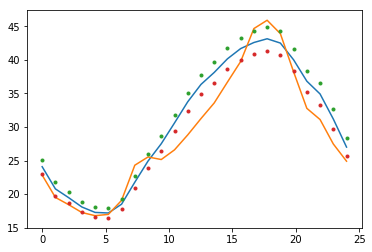

In [18]:
X  = np.linspace(0,24,24)
plt.plot(X,y_pred, label='forecast')
plt.plot(X,y_true, label = 'actual')
plt.plot(X,y_ci_u, '.',label = 'upper_level')
plt.plot(X,y_ci_l, '.',label = 'lower_level')

